C:\Users\Louis\anaconda3\envs\HTSAT_env\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


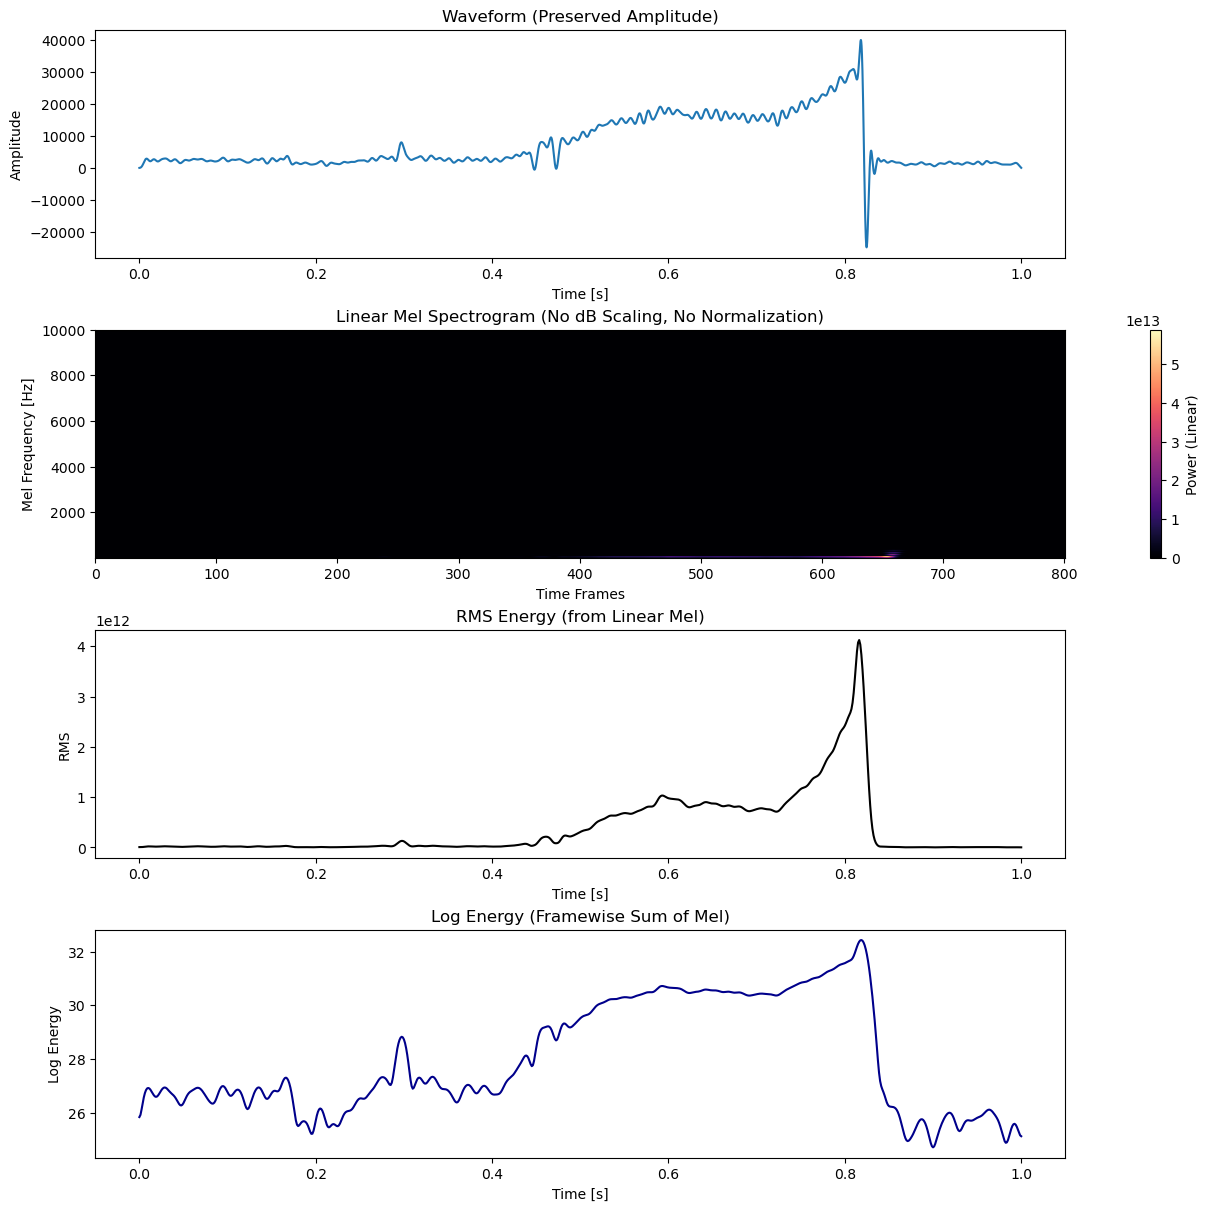

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import librosa

# === Load raw waveform from file (preserve original amplitude) ===
file_path = r"C:\Users\Louis\PycharmProjects\HTS-Audio-Transformer\workspace\esc-50\raw\ESC-50-master\audio\l6s9.95s10.1_P2S2Girders2H2300_cycle_078.wav"
waveform, sr = torchaudio.load(file_path)

# Undo torchaudio scaling if waveform was originally int16
waveform = waveform * 32768

# === Resample to 32 kHz if needed ===
target_sr = 32000
if sr != target_sr:
    waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)(waveform)
    sr = target_sr

# Use mono if stereo
if waveform.shape[0] > 1:
    waveform = waveform[0].unsqueeze(0)

# === Compute STFT ===
n_fft = 1024
hop_length = 40
win_length = n_fft

spectrogram = torch.stft(
    waveform,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=torch.hann_window(n_fft),
    center=True,
    return_complex=True
)
power_spec = spectrogram.abs() ** 2  # (1, freq, time)

# === Create custom mel filter bank (no normalization) ===
n_mels = 256
fmin = 10
fmax = 10000

mel_basis = librosa.filters.mel(
    sr=sr,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    norm=None  # <- disables mel normalization
)

mel_basis_tensor = torch.tensor(mel_basis, dtype=torch.float32)

# === Apply mel filter bank ===
mel_spec = torch.matmul(mel_basis_tensor, power_spec[0]).numpy()  # shape: (n_mels, time)

# === Compute RMS and log-energy from mel_spec ===
rms = np.sqrt(np.mean(mel_spec ** 2, axis=0))
log_energy = np.log(np.sum(mel_spec, axis=0) + 1e-10)
time_axis = np.linspace(0, len(waveform[0]) / sr, mel_spec.shape[1])

# === Plot ===
fig, axs = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

# 1. Time-Domain Waveform
waveform_np = waveform[0].numpy()
axs[0].plot(np.linspace(0, len(waveform_np) / sr, len(waveform_np)), waveform_np)
axs[0].set_title("Waveform (Preserved Amplitude)")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Amplitude")

# 2. Linear Mel Spectrogram
im = axs[1].imshow(mel_spec, origin='lower', aspect='auto', cmap='magma',
                   extent=[0, mel_spec.shape[1], fmin, fmax])
axs[1].set_title("Linear Mel Spectrogram (No dB Scaling, No Normalization)")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("Mel Frequency [Hz]")
fig.colorbar(im, ax=axs[1], label='Power (Linear)')

# 3. RMS Energy
axs[2].plot(time_axis, rms, color='black')
axs[2].set_title("RMS Energy (from Linear Mel)")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("RMS")

# 4. Log Energy
axs[3].plot(time_axis, log_energy, color='darkblue')
axs[3].set_title("Log Energy (Framewise Sum of Mel)")
axs[3].set_xlabel("Time [s]")
axs[3].set_ylabel("Log Energy")

plt.show()
